## Step 1: Import Libraries

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras import optimizers
from collections import deque 
import random 

## Step 2: Set Log

In [3]:
import logging
import os 

# Define the log folder and file name
log_folder = 'logs'
log_file = 'batch.log'

# Create the log folder if it doesn't exist
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Define the full path to the log file
log_path = os.path.join(log_folder, log_file)

# Create a logger with the name of the current module
logger = logging.getLogger(__name__)

# Specify the file handler to output logs to a file named 'logs.log', in write mode ('w')
file_handler = logging.FileHandler(log_path, mode='w')  # 'w' stands for write

# Set the logging level for the file handler
file_handler.setLevel(logging.INFO)  # Set to the desired level (e.g., WARNING)

# Define the format of the log messages
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Clear existing handlers (if any) and add the file handler to the logger , avoid duplicate logs
logger.handlers = []  

# connect to log file using logger.addHandler(file_handler)
logger.addHandler(file_handler)

# Example of logging a WARNING message
logger.warning("-------- Start --------")

## Step 3: Create Neural Network

In [4]:
#-- Inheritate from Sequential Class
class NeuralNetwork(Sequential):
    #-- number of observation and action 
    def __init__(self, observation_space, action_space, learning_rate):
        #-- Constructor , we will set 2 hidden layer and 24 node for each 
        #-- super().__init__() : USe for build DeepLearning
        super().__init__()
        #-- add input and first hidden layer
        self.add(Dense(24, input_shape=(observation_space,), activation = "relu"))
        self.add(Dense(24,activation = "relu"))
        self.add(Dense(action_space,activation="linear"))
        self.compile(loss='mse',optimizer = optimizers.Adam(learning_rate=learning_rate))

    #-- State = X , target_output = Y (X data , Y Label)
    def train(self,state,target_output):
        self.fit(state, target_output, epochs =1, verbose= 0)

    #-- Predict 
    def predict_expected_reward_for_each_action(self,state):
        return self.predict(state)

## Step 4: Create Agen

In [5]:
class Agent():
    def __init__(self, epsilon_initial=0.5):
        #-- 1 million data store max
        self.memory = deque(maxlen = 10000000)
        #--
        self.batch_size = 20
        self.learning_rate = 0.001
        #-- discount_factor 
        self.discount_factor = 0.95
        self.epsilon = epsilon_initial
        #-- decay_factor for discount eplsilon 
        self.decay_factor = 0.99
        #-- for append the data inside the function of class , store the data 
        self.reward_for_each_episode = []
        self.batch_length_store = []
        self.batch_store = []
        self.state_store = []
        self.state_next_store = []
        self.action_store = []
        self.reward_store = []
        self.qupdate_store =[]
        self.qvalue_before_adj_store = []
        self.qvalue_after_adj_store = []
        self.terminal_store = [] 
        self.neural_store = []
        self.epsilon_store = []
        self.q_values_train_store = 0
        self.run_count = 0
        self.reward_pergame_store = []
        #-- Neural Network
        self.neural_network = NeuralNetwork(4,2,self.learning_rate)


    def play(self, env, number_of_episode=10, isRender = False):
    # def play(self, env, number_of_episode=3000):
        for i_episode in range(number_of_episode):
            if(self.epsilon < 0.025):
                    print("Epsilon is Lower than Value")
                    print("Last Episode Run :", i_episode)
                    break
            print("Episode {} of {} ".format(i_episode + 1, number_of_episode))

            #-- state has 4 thing observation
            state, info = env.reset()
            #-- state : 1x4 array state 
            state = np.reshape(state,[1,4])

            # self.epsilon *= self.decay_factor

            total_reward = 0
            end_game = False
            truncated = False
            
            while not (end_game or truncated):
                if isRender:
                    env.render()
                if self.__with_probability(self.epsilon):
                    #-- 
                    action = self.__getActionByRandomly(env)
                else:
                    #--
                    action = self.__getActionWithHighestExpectedReward(state)
                
                #-- Must have both end_game and truncated for end the loop 
                new_state, reward, end_game, truncated ,info = env.step(action)
                new_state = np.reshape(new_state, [1,4])
                if end_game or truncated:
                    reward = -200
                    self.run_count += 1
                else: 
                    total_reward += reward       
                self.reward_pergame_store.append([i_episode,reward])
                #-- เก็บข้อมูลในหน่วยความจำ

                self.remember(state,action,reward,new_state,end_game or truncated)
                state = new_state
                self.experience_replay()
            self.reward_for_each_episode.append(total_reward)

    def __with_probability(self, probability):
        return np.random.random() < probability

    def __getActionByRandomly(self, env):
        return env.action_space.sample()

    def __getActionWithHighestExpectedReward(self, state):
        return np.argmax(self.neural_network.predict_expected_reward_for_each_action(state)[0])

    def __getExpectedReward(self, state):
        return np.max(self.neural_network.predict_expected_reward_for_each_action(state)[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    #-- Function Train 
    def experience_replay(self):
        #-- if data is less than 20 do nothing 
        if len(self.memory) < self.batch_size:
            return 
        #-- Get Random Sample
        batch = random.sample(self.memory, self.batch_size)

        #-- log batch
        batch_length = len(batch)
        self.batch_length_store.append(batch_length)
        self.batch_store.append(batch)
        logger.warning(f"length of batch is : {batch_length}")
        
        for state, action, reward, state_next, terminal in batch:
            #-- Discover Data Using Append
            self.state_store.append(state)
            self.state_next_store.append(state_next)
            self.action_store.append(action)
            self.reward_store.append(reward)
            self.terminal_store.append(terminal)

            #--
            q_update = reward
            if not terminal:
                q_update = reward + self.discount_factor * self.__getExpectedReward(state_next)
            self.qupdate_store.append([q_update,action])
            #-- q value neural network
            q_values = self.neural_network.predict_expected_reward_for_each_action(state)
            q_values_copy = q_values.copy()
            self.qvalue_before_adj_store.append(q_values_copy)
            q_values[0][action] = q_update
            self.neural_network.train(state,q_values)
            self.qvalue_after_adj_store.append(q_values)
            self.q_values_train_store = q_values

        #--
        self.epsilon *= self.decay_factor
        self.epsilon_store.append(self.epsilon)

## Step 5: Run the Agent

Episode 1 of 2 
1/1 [==============================] - 0s 13ms/step
Episode 2 of 2 
1/1 [==============================] - 0s 14ms/step


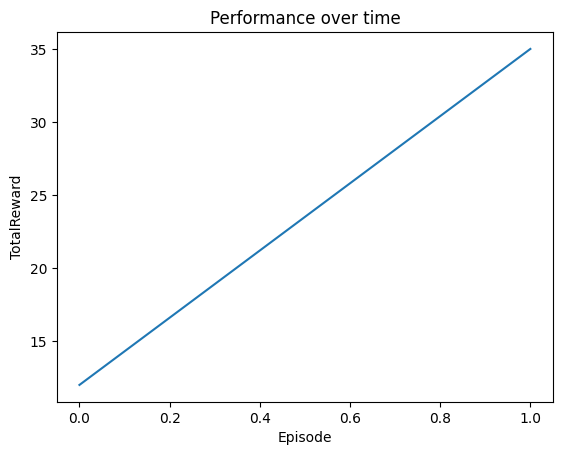

In [12]:
#--  gym.make('CartPole-v1',render_mode="human") : This make process very slow
# env = gym.make('CartPole-v1',render_mode="human")
env = gym.make('CartPole-v1')
agent = Agent()
qtable_store = agent.play(env, 20
                          , False)
# agent.play(env)
plt.title("Performance over time")
plt.ylabel('TotalReward')
plt.xlabel('Episode')
plt.plot(agent.reward_for_each_episode)
plt.show()